In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

# Gensim
#!pip install --upgrade gensim
#!pip install gensim==3.8.3
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#nltk
import nltk
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

# wordcloud
#from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sundaracharya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import spacy
from spacy.lang.en.examples import sentences
from sklearn.model_selection import train_test_split

In [4]:
newsgroups_data = fetch_20newsgroups(subset='all',random_state=32,shuffle=True,remove=('headers', 'footers', 'qutes'))
newsgroups_df = pd.DataFrame({'News':newsgroups_data.data,'Target':newsgroups_data.target})

In [12]:
newsgroups_train = newsgroups_df.sample(frac=0.8)
newsgroups_test = newsgroups_df[~newsgroups_df.isin(newsgroups_train)].dropna(how = 'all')
print('Train: {} \nTest: {} '.format(newsgroups_train.shape,newsgroups_test.shape))

Train: (15077, 2) 
Test: (3769, 2) 


In [ ]:
#newsgroups_data = fetch_20newsgroups(subset='all',random_state=32,shuffle=True,remove=('headers', 'footers', 'qutes'))
#newsgroups_train = fetch_20newsgroups(subset='train',random_state=32,shuffle=True , remove=('headers', 'footers', 'qutes'))
#newsgroups_test = fetch_20newsgroups(subset='test',random_state=32,shuffle=True , remove=('headers', 'footers', 'qutes'))

In [ ]:
#df_train = pd.DataFrame({'News':newsgroups_train.data,'Target':newsgroups_train.target})
#df_train['Target_name'] = df_train['Target'].apply(lambda x:newsgroups_train.target_names[x])
#df_train.head()

In [16]:
df_train = newsgroups_train
df_train['Target_name'] = df_train['Target'].apply(lambda x:newsgroups_data.target_names[x])
df_train.shape

(15077, 3)

In [17]:
df_test = newsgroups_test
df_test['Target']=df_test['Target'].astype(int)
df_test['Target_name'] = df_test['Target'].apply(lambda x:newsgroups_data.target_names[x])
df_test.shape

(3769, 3)

In [ ]:
#df_test = pd.DataFrame({'News':newsgroups_test.data,'Target':newsgroups_test.target})
#df_test['Target_name'] = df_test['Target'].apply(lambda x:newsgroups_test.target_names[x])
#df_test.head()

# Preprocessing

### remove senders info and blank/newline characters

In [18]:
news_train_data = df_train.News.values.tolist()

In [19]:
# removing new line
news_train_data = [re.sub('\s+', ' ', sent) for sent in news_train_data]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/4t/2rm5x3sn057fc9fch2_h0p_c0000gn/T/ipykernel_7329/3435132558.py:2: DeprecationWarning: invalid escape sequence \s
  news_train_data = [re.sub('\s+', ' ', sent) for sent in news_train_data]


In [20]:
# removing emails
news_train_data = [re.sub('\S*@\S*\s?', '', sent) for sent in news_train_data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
/var/folders/4t/2rm5x3sn057fc9fch2_h0p_c0000gn/T/ipykernel_7329/719524970.py:2: DeprecationWarning: invalid escape sequence \S
  news_train_data = [re.sub('\S*@\S*\s?', '', sent) for sent in news_train_data]


In [21]:
# removing single quotes
news_train_data = [re.sub("\'", "", sent) for sent in news_train_data]

In [22]:
news_train_data[0]

'In article (Brian Glendenning) writes: |> |> Alas, we too will have to stop using it. |> |> Brian We where following version of xv and I have been very surprise to discover that the new version is a shareware: What a pitty !!! :-( . What I found on the Inthernet was the freeware. I make myself a freeware and I spent long time on it but I dont plain to make paid to use it. I think if evrybody spent some time to make freeware, evrybody will be paid by the use of other freeware. Here we will stay with XV 2 and drop XV 3. '

## stopwords

In [23]:
#stopwords
stop_words = gensim.parsing.preprocessing.STOPWORDS
extra_stop_words = frozenset(['from', 'subject', 're', 'edu', 'use'])
stop_words.union(extra_stop_words)

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'


### Lemmatization and stemming

In [24]:
# lemmatization
stemmer = PorterStemmer()
def lemmatize_stem(tokendata):
  return stemmer.stem(WordNetLemmatizer().lemmatize(tokendata,pos='v'))

# Tokenize and lemmatize
def tokenLemm(data):
    result=[]
    for token in gensim.utils.simple_preprocess(data) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
          result.append(lemmatize_stem(token))
    return result

In [25]:
def convertedData(data):
    datalist = []
    for d in data:
        datalist.append(tokenLemm(d))
    return datalist

In [26]:
df_train['News1']=convertedData(news_train_data)

In [27]:
#data preview
df_train

,News,Target,Target_name,News1
16964,In article <BGLENDEN.93Apr29182711@colobus.cv....,5,comp.windows.x,"[articl, brian, glenden, write, ala, stop, bri..."
5302,From the June newsletter of the Latin Liturgy ...,15,soc.religion.christian,"[june, newslett, latin, liturgi, associ, mail,..."
9982,Oops! I came across this file from last year....,9,rec.sport.baseball,"[oop, come, file, year, think, enjoy, thought,..."
9854,Help!\n\nI'm trying to run dxterm's (DECs' xte...,5,comp.windows.x,"[help, tri, dxterm, dec, xterm, decstat, ultri..."
6341,In article <C5yC1K.F84@news.cso.uiuc.edu> ptg2...,17,talk.politics.mideast,"[articl, pano, tamamidi, write, sure, memori, ..."
...,...,...,...,...
6459,Interesting. I'd fight the ticket. First off...,8,rec.motorcycles,"[interest, fight, ticket, there, chanc, wont, ..."
4028,Who the hell is this guy David Davidian. I thi...,17,talk.politics.mideast,"[hell, david, davidian, think, talk, david, be..."
3981,In article <1993Apr16.163712.2466@VFL.Paramax....,9,rec.sport.baseball,"[articl, dougherti, write, philli, penna, base..."
8803,Archive-name: cryptography-faq/part05\nLast-mo...,11,sci.crypt,"[archiv, cryptographi, modifi, crypt, product,..."


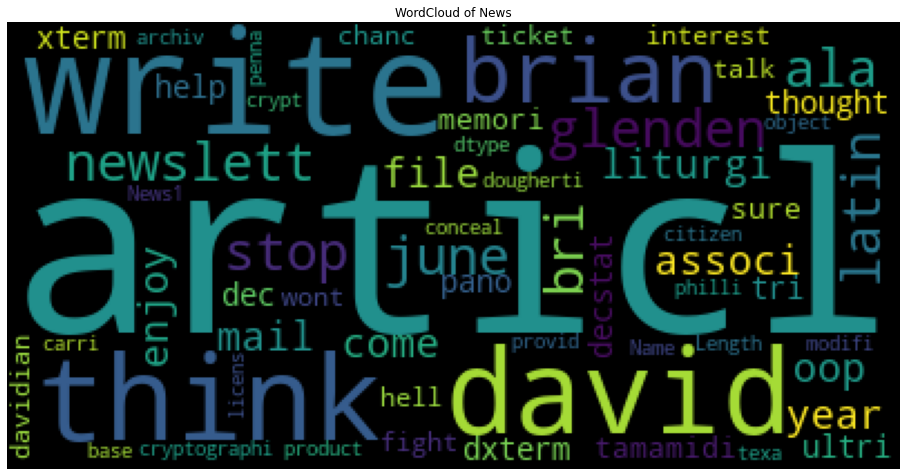

In [28]:
# plot word count for news text
#!pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',max_words=200).generate(str(df_train['News1']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## STOPWORDS, bigrams, and trigrams

In [29]:
#df['News1']
processed_data = df_train['News1']
#bigrams
bigram = gensim.models.Phrases(processed_data,min_count=5, threshold = 100)
bigram_model = gensim.models.phrases.Phraser(bigram)
#trigram
trigram = gensim.models.Phrases(bigram[processed_data],threshold=100)
trigram_model = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_model[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_model[bigram_model[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out
data_words_nostops = remove_stopwords(processed_data)
data_words_bigrams = make_bigrams(data_words_nostops)

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])
print(data_lemmatized[:1]) #let's see the first document lemmatized data

[['articl', 'write', 'ala', 'stop', 'follow', 'inthernet', 'freewar', 'freewar', 'spend', 'long', 'time', 'plain', 'pay', 'think', 'evrybodi', 'spend', 'time', 'freewar', 'evrybodi', 'pay', 'freewar', 'stay', 'drop']]


## Creating dictionary and corpus

In [36]:
# Create Dictionary 
#id2word = corpora.Dictionary(df['News1'])  
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]
# View 
#corpus_train_val = corpus[:int(len(corpus)*0.8)]
#print(corpus[:1])

In [32]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the keyword of topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.066*"write" + 0.045*"know" + 0.037*"think" + 0.031*"time" + 0.029*"good" + 0.026*"articl" + 0.023*"want" + 0.022*"come" + 0.018*"thing" + 0.017*"look"'), (1, '0.065*"money" + 0.052*"screen" + 0.051*"troubl" + 0.036*"choic" + 0.036*"planet" + 0.027*"orbit" + 0.025*"minut" + 0.024*"early" + 0.021*"loss" + 0.020*"combin"'), (2, '0.025*"inform" + 0.025*"program" + 0.023*"note" + 0.023*"post" + 0.022*"mail" + 0.021*"send" + 0.021*"list" + 0.019*"avail" + 0.018*"number" + 0.016*"user"'), (3, '0.094*"sourc" + 0.090*"disk" + 0.069*"market" + 0.058*"feder" + 0.053*"featur" + 0.039*"absolut" + 0.038*"voic" + 0.034*"round" + 0.031*"experi" + 0.029*"doubl"'), (4, '0.027*"point" + 0.026*"mean" + 0.026*"question" + 0.023*"differ" + 0.021*"case" + 0.021*"person" + 0.020*"reason" + 0.018*"fact" + 0.015*"read" + 0.014*"true"'), (5, '0.262*"window" + 0.107*"card" + 0.048*"video" + 0.046*"font" + 0.044*"implement" + 0.043*"memori" + 0.043*"size" + 0.036*"printer" + 0.033*"board" + 0.031*"port"'),

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=df['News1'], dictionary=id2word, coherence='c_v')
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.539761333707174

Coherence Score:  0.40217297210717157


In [ ]:
for i in range(5,100,5):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                                eta=0.01,
                                           per_word_topics=True)
    
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    # a measure of how good the model is. lower the better.|

    # Compute Coherence Score
    #coherence_model_lda = CoherenceModel(model=lda_model, texts=df['News1'], dictionary=id2word, coherence='c_v')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


Perplexity:  -35.91657672454162

Coherence Score:  0.40517100341859125

Perplexity:  -35.79827571765628

Coherence Score:  0.45546587162458574
